In [ ]:
"""
BIOINFORMATICS: LAB08
@author: Irene Benedetto
"""


import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dense, Flatten, Reshape
import tensorflow as tf
import tensorflow_datasets as tfds

from tqdm import tqdm

# Basic autoencoder

## Model

In [ ]:
class AutoEncoder(tf.keras.Model):
    """
      The class AutoEncoder is a simple implementation of a AutoEncoder network.
      It is composed by two part:
        - an encoder: which projects the image into a latent space
        - a decoder: that, starting from the latent representation reconstruct the original image

    """
    def __init__(self, latent_dim, input_dim, output_dim):
        super(AutoEncoder, self).__init__()

        # encoder
        self.conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')
        self.pool1 = MaxPooling2D(pool_size=(2, 2))
        self.conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')
        self.pool2 = MaxPooling2D(pool_size=(2, 2))
        self.conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')

        #decoder
        self.conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')
        self.up1 = UpSampling2D((2,2))
        self.conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')
        self.up2 = UpSampling2D((2,2))
        self.decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')

        self.perceptual_loss = False
        
        
    def forward_encoder(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x) 
        x = self.conv3(x)
        return x
    
    def forward_decoder(self, x):
        x = self.conv4(x)
        x = self.up1(x)
        x = self.conv5(x)
        x = self.up2(x)
        x = self.decoded(x)
        
        return x

    def call(self, x):
        # encoder
        x = self.forward_encoder(x)
        # decoder
        x = self.forward_decoder(x)
        return x

    def compile(self, optimizer, loss, metrics, perceptual_loss=False):

        self.optimizer = optimizer
        self.compiled_loss = loss
        self.compiled_metrics = metrics
        
        if perceptual_loss:
            self.vgg = VGG16(include_top=False, weights='imagenet')
            self.perceptual_loss = True

        

    def train_step(self, data):
        x, y = data
        params = self.conv1.trainable_weights + self.conv2.trainable_weights + self.conv3.trainable_weights + self.conv4.trainable_weights + self.conv5.trainable_weights + self.decoded.trainable_weights
        
        with tf.GradientTape() as tape:
            y_pred = self.call(x)
            if not self.perceptual_loss:
                loss = self.compiled_loss(y, y_pred)
            else:
                x = tf.keras.applications.vgg16.preprocess_input(x*255)
                y_pred_vgg = tf.keras.applications.vgg16.preprocess_input(y_pred*255)
                y_true_vgg = self.vgg.call(x)
                y_pred_vgg = self.vgg.call(y_pred_vgg)
                loss = self.compiled_loss(y, y_pred, y_true_vgg, y_pred_vgg)

        grads = tape.gradient(loss, params)
        self.optimizer.apply_gradients(zip(grads, params))
        return {'loss': loss}


In [ ]:
ds = tfds.load('colorectal_histology', split='train', as_supervised=True)
ds = ds.batch(128)
ds = ds.map(lambda img, l: (tf.image.convert_image_dtype(img, dtype=tf.float32), l))
ds = ds.map(lambda img, l: (tf.image.resize(img, [148, 148]), tf.image.resize(img, [148, 148])))

for x, y, in ds:
    input_dim = x.shape.as_list()
    output_dim = y.shape.as_list()
    break
print(f'Input shape: {input_dim}')
print(f'Output shape: {output_dim}')

latent_dim = 128

model = AutoEncoder(latent_dim, input_dim, output_dim)

loss = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
metrics = None

model.compile(optimizer, loss, metrics)

N_EPOCH = 10

for epoch in range(N_EPOCH):
    for data in tqdm(ds):
        history = model.train_step(data)

    print(f'Epoch {epoch}/{N_EPOCH}, loss: {history["loss"]}')


    

  0%|          | 0/40 [00:00<?, ?it/s]

Input shape: [128, 148, 148, 3]
Output shape: [128, 148, 148, 3]


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 0/10, loss: 0.024784665554761887


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/10, loss: 0.010312722995877266


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 2/10, loss: 0.007408310659229755


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 3/10, loss: 0.005439807195216417


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 4/10, loss: 0.0045888894237577915


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 5/10, loss: 0.004162799101322889


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 6/10, loss: 0.0038745105266571045


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 7/10, loss: 0.003585444064810872


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 8/10, loss: 0.0033788580913096666


100%|██████████| 40/40 [00:15<00:00,  2.53it/s]

Epoch 9/10, loss: 0.0032239528372883797


## Results

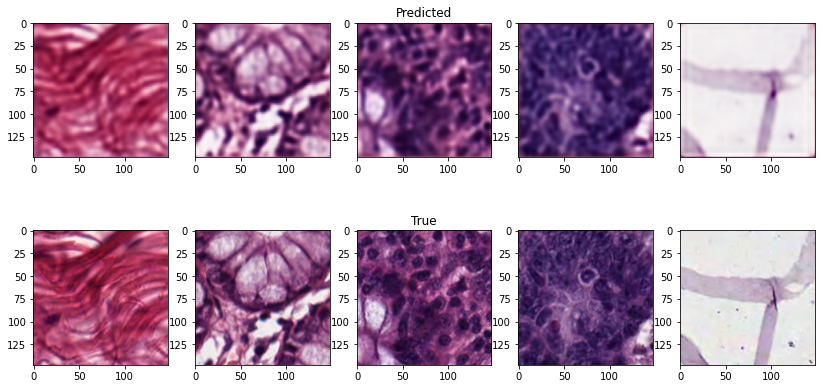

In [ ]:
from matplotlib import pyplot as plt
N_BATCH = 5
figs, axs = plt.subplots(nrows=2, ncols=N_BATCH, figsize=(14, 7))

for data in ds.unbatch().batch(N_BATCH):
        
        X, Y = data
        imgs = model(x)
        
        for i, (y, img) in enumerate(zip(Y, imgs)):
          y *= 255
          img *= 255
          y = tf.keras.preprocessing.image.array_to_img(y)
          img = tf.keras.preprocessing.image.array_to_img(img)
          axs[0, 2].set_title('Predicted')
          axs[0, i].imshow(img)
          axs[1, 2].set_title('True')
          axs[1, i].imshow(y)
        break

# Autoencoder with perceptual loss

## Percetual Loss

In [ ]:
# to debug
class DoubleMSELoss(tf.keras.losses.Loss):
    def __init__(self, weight=0.1):
        
        self.weight = weight
        self.name = 'DoubleMSELoss'

    def __call__(self, y_true, y_pred, y_true_vgg, y_pred_vgg):
        loss1 = tf.reduce_mean((y_true - y_pred)**2)
        loss2 = tf.reduce_mean((y_true_vgg - y_pred_vgg)**2)
        return loss1 + self.weight*loss2

In [ ]:
from tensorflow.keras.applications import VGG16
# autoencoder with perceptual loss

ds = tfds.load('colorectal_histology', split='train', as_supervised=True)
ds = ds.batch(128)
ds = ds.map(lambda img, l: (img, l))
ds = ds.map(lambda img, l: (tf.image.convert_image_dtype(img, dtype=tf.float32), l))
ds = ds.map(lambda img, l: (tf.image.resize(img, [148, 148]), tf.image.resize(img, [148, 148]))).cache().prefetch(tf.data.experimental.AUTOTUNE)


for (x, y) in ds:
    input_dim = x.shape.as_list()
    output_dim = y.shape.as_list()
    break

print(f'Input shape: {input_dim}')
print(f'Output shape: {output_dim}')

latent_dim = 128

model = AutoEncoder(latent_dim, input_dim, output_dim)

loss = DoubleMSELoss()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
metrics = None

model.compile(optimizer, loss, metrics, perceptual_loss=True)

N_EPOCH = 10

for epoch in range(N_EPOCH):
    for data in tqdm(ds): 
        history = model.train_step(data)

    print(f'Epoch {epoch}/{N_EPOCH}, loss: {history["loss"]}')



Input shape: [128, 148, 148, 3]
Output shape: [128, 148, 148, 3]
58892288/58889256 [==============================] - 1s 0us/step


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 0/10, loss: 3.1567699909210205


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/10, loss: 2.5334839820861816


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 2/10, loss: 2.0857300758361816


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 3/10, loss: 1.8009779453277588


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 4/10, loss: 1.5931315422058105


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 5/10, loss: 1.4372562170028687


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 6/10, loss: 1.3602838516235352


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 7/10, loss: 1.269088625907898


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 8/10, loss: 1.20277738571167


100%|██████████| 40/40 [01:40<00:00,  2.50s/it]

Epoch 9/10, loss: 1.1187891960144043


## Results

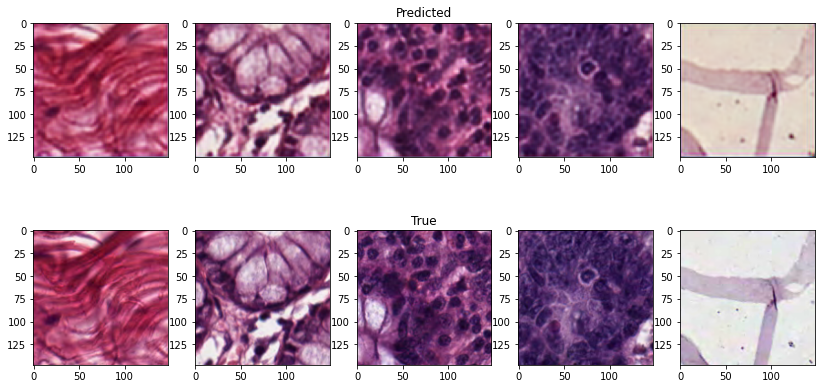

In [ ]:
import matplotlib.pyplot as plt
N_BATCH = 5
figs, axs = plt.subplots(nrows=2, ncols=N_BATCH, figsize=(14, 7))

for data in ds.unbatch().batch(N_BATCH):

    X, Y = data
    imgs = model(x)

    for i, (y, img) in enumerate(zip(Y, imgs)):
        y *= 255
        img *= 255
        
        y = tf.keras.preprocessing.image.array_to_img(y)
        img = tf.keras.preprocessing.image.array_to_img(img)
        
        axs[0, 2].set_title('Predicted')
        axs[0, i].imshow(img)
        axs[1, 2].set_title('True')
        axs[1, i].imshow(y)
        
    break

In [ ]:
# variational autoencoder
!pip install -q tensorflow-probability

# to generate gifs
!pip install -q imageio
!pip install -q git+https://github.com/tensorflow/docs

# Variational autoencoder with Functional API

## The encoder model

In [ ]:
latent_dim = 256

# ENCODER model
inputs = tf.keras.layers.Input(shape=[128, 128, 3])
x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Flatten()(x)
mean = Dense(units = latent_dim)(x)
logvar = Dense(units = latent_dim)(x)

encoder = tf.keras.Model(inputs=inputs, outputs=[mean, logvar], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 64)   18496       max_pooling2d[0][0]              
____________________________________________________________________________________________

## The decoder model

In [ ]:
inputs = tf.keras.layers.Input(shape=[latent_dim])
x = Reshape(target_shape=(8, 8, 4))(inputs)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2,2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2,2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2,2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2,2))(x)
x = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

decoder = tf.keras.Model(inputs=inputs, outputs=x, name='decoder')

decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256)]             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 4)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         4736      
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)        73792     
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 64)        3692

## The complete model

In [ ]:
class VariationalAutoencoder(tf.keras.Model):
    def __init__(self, encoder, decoder, beta):
        super(VariationalAutoencoder2, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta

    def call(self, x):
        mean, logvar = self.encoder(x)
        print(mean.shape, logvar.shape)
        self.add_loss(self.kld(mean, logvar))
        x = self.reparametrize(mean, logvar)
        x = self.decoder(x)
        return x

    def kld(self, mean, logvar):
        kld = -.5*tf.reduce_sum((1 + logvar) - mean**2 - tf.exp(logvar))
        return kld*self.beta

    def reparametrize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape.as_list())
        x = mean + eps*tf.exp(logvar)
        return x

In [ ]:
model = VariationalAutoencoder(encoder=encoder, decoder=decoder, beta = 0.1)

In [ ]:
loss =  tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
metrics = tf.keras.metrics.MeanSquaredError()
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [ ]:
ds = tfds.load('colorectal_histology', split='train', as_supervised=True)
ds = ds.batch(128, drop_remainder=True)
ds = ds.map(lambda img, l: (img, l))
ds = ds.map(lambda img, l: (tf.image.convert_image_dtype(img, dtype=tf.float32), l))
ds = ds.map(lambda img, l: (tf.image.resize(img, [128, 128]), tf.image.resize(img, [128, 128]))).cache().prefetch(tf.data.experimental.AUTOTUNE)

for (x, y) in ds:
    input_dim = x.shape.as_list()
    output_dim = y.shape.as_list()
    break

N_EPOCHS = 30

print(f'Input shape: {input_dim}')
print(f'Output shape: {output_dim}')

history = model.fit(ds, epochs=N_EPOCHS)

Input shape: [128, 128, 128, 3]
Output shape: [128, 128, 128, 3]
Epoch 1/30
39/39 [==============================] - 12s 193ms/step - loss: 62.8047 - mean_squared_error: 0.0850
Epoch 2/30
39/39 [==============================] - 7s 174ms/step - loss: 0.6067 - mean_squared_error: 0.0817
Epoch 3/30
39/39 [==============================] - 7s 175ms/step - loss: 0.1986 - mean_squared_error: 0.0816
Epoch 4/30
39/39 [==============================] - 7s 176ms/step - loss: 0.1258 - mean_squared_error: 0.0815
Epoch 5/30
39/39 [==============================] - 7s 175ms/step - loss: 0.0867 - mean_squared_error: 0.0814
Epoch 6/30
39/39 [==============================] - 7s 173ms/step - loss: 0.0831 - mean_squared_error: 0.0813
Epoch 7/30
39/39 [==============================] - 7s 172ms/step - loss: 0.0824 - mean_squared_error: 0.0813
Epoch 8/30
39/39 [==============================] - 7s 172ms/step - loss: 0.0820 - mean_squared_error: 0.0812
Epoch 9/30
39/39 [==============================] - 7

## Results

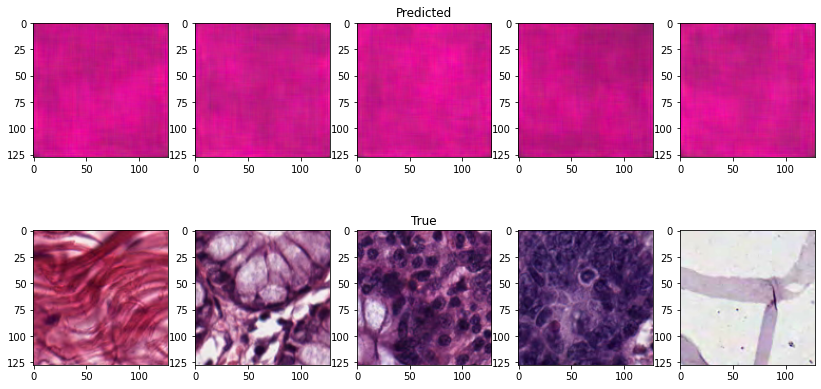

In [ ]:
from matplotlib import pyplot as plt
N_BATCH = 5
figs, axs = plt.subplots(nrows=2, ncols=N_BATCH, figsize=(14, 7))

for data in ds.unbatch().batch(N_BATCH):
        
    X, Y = data
    
    imgs = model.predict(X, batch_size=N_BATCH)
    
    for i, (y, img) in enumerate(zip(Y, imgs)):
        y *= 255
        img *= 255
        y = tf.keras.preprocessing.image.array_to_img(y)
        img = tf.keras.preprocessing.image.array_to_img(img)
        
        axs[0, 2].set_title('Predicted')
        axs[0, i].imshow(img)
        axs[1, 2].set_title('True')
        axs[1, i].imshow(y)
    break

# Old VAE (not working)


## Loss

In [ ]:
class ReconstructionLossKLD(tf.keras.losses.Loss):
    def __init__(self, beta):
        self.beta = beta
        self.name = 'ReconstructionLossKLD'
        self.name_scope =  'ReconstructionLossKLD'

    def call(self, y, y_pred, mean, logvar):
        kld = -.5*tf.reduce_sum((1 + logvar) - mean**2 - tf.exp(logvar))
        #reconstruction_loss = -tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(y, y_pred), axis=[1, 2, 3])
        reconstruction_loss = tf.reduce_mean((y - y_pred)**2)
        return tf.reduce_mean(reconstruction_loss) + self.beta*kld


class KLDivergence(tf.keras.losses.Loss):
    def __init__(self, beta):
        self.beta = beta
        self.name = 'KLDivergence'

    def call(y, y_pred, mean, logvar, z):

        log2pi = tf.math.log(2. * np.pi)

        cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=y_pred, labels=y)
        logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3]) # reconstruction loss

        # kldivergence
        logpz = tf.reduce_sum(-.5 * ((z - 0) ** 2. * tf.exp(-0) + 0 + log2pi), axis=1)
        logqz_x = tf.reduce_sum(-.5 * ((z - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi), axis=1)
        return -tf.reduce_mean(logpx_z + logpz - logqz_x)

In [ ]:
ds = tfds.load('colorectal_histology', split='train', as_supervised=True)
ds = ds.batch(128)
ds = ds.map(lambda img, l: (img, l))
ds = ds.map(lambda img, l: (tf.image.convert_image_dtype(img, dtype=tf.float32), l))
ds = ds.map(lambda img, l: (tf.image.resize(img, [128, 128]), tf.image.resize(img, [128, 128]))).cache().prefetch(tf.data.experimental.AUTOTUNE)

for (x, y) in ds:
    input_dim = x.shape.as_list()
    output_dim = y.shape.as_list()
    break

print(f'Input shape: {input_dim}')
print(f'Output shape: {output_dim}')
N_EPOCH = 20
for epoch in range(N_EPOCH):
    for data in tqdm(ds): 
        history = var2.train_step(data)

    print(f'Epoch {epoch}/{N_EPOCH}, loss: {history["loss"]}')

In [ ]:
class VariationalAutoencoder(tf.keras.Model):
    def __init__(self, latent_dim):
        super(VariationalAutoencoder, self).__init__()
        # encoder: return the posterior probability distribution q(z|x) of the latent representation 
    
        self.conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')
        self.pool1 = MaxPooling2D(pool_size=(2, 2))
        self.conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')
        self.pool2 = MaxPooling2D(pool_size=(2, 2))
        self.conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')
        self.flatten = Flatten()
        self.mean_variance = Dense(units = latent_dim + latent_dim) # meand and variance of the posterior distribution

        # decoder: return the posterior probability distribution p(x|z) of the observation
        self.reshape = tf.keras.layers.Reshape(target_shape=(8, 8, 4))
        self.conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')
        self.up1 = UpSampling2D((2,2))
        self.conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')
        self.up2 = UpSampling2D((2,2))
        self.conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')
        self.up3 = UpSampling2D((2,2))
        self.conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')
        self.up4 = UpSampling2D((2,2))
        self.decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')

        self.latent_dim = latent_dim

    def forward_encoder(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.flatten(x)
        x = self.mean_variance(x)
        return x
    
    def forward_decoder(self, x):
        x = self.reshape(x)
        x = self.conv4(x)
        x = self.up1(x)
        x = self.conv5(x)
        x = self.up2(x)
        x = self.conv6(x)
        x = self.up3(x)
        x = self.conv7(x)
        x = self.up4(x)
        x = self.decoded(x)
        return x
    

    def compile(self, optimizer, loss, metrics):
        self.optimizer = optimizer
        self.compiled_loss = loss
        self.compiled_metrics = metrics

    def reparametrize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        x = mean + eps*tf.exp(logvar)
        return x

    def train_step(self, data):
        x, y = data

        params = self.conv1.trainable_weights + self.conv2.trainable_weights + self.conv3.trainable_weights + self.conv4.trainable_weights 
        params += self.conv5.trainable_weights + self.conv6.trainable_weights + self.conv7.trainable_weights + self.decoded.trainable_weights + self.mean_variance.trainable_weights
        
        with tf.GradientTape() as tape:
            mean_logvar = self.forward_encoder(x)
            mean, logvar = mean_logvar[:, :self.latent_dim], mean_logvar[:, self.latent_dim:]

            z = self.reparametrize(mean, logvar)
            y_pred = self.forward_decoder(z)

            loss = self.compiled_loss(y, y_pred, mean, logvar)

        grads = tape.gradient(loss, params)
        self.optimizer.apply_gradients(zip(grads, params))

        return {'loss': loss}

In [ ]:
ds = tfds.load('colorectal_histology', split='train', as_supervised=True)
ds = ds.batch(128)
ds = ds.map(lambda img, l: (img, l))
ds = ds.map(lambda img, l: (tf.image.convert_image_dtype(img, dtype=tf.float32), l))
ds = ds.map(lambda img, l: (tf.image.resize(img, [128, 128]), tf.image.resize(img, [128, 128]))).cache().prefetch(tf.data.experimental.AUTOTUNE)

for (x, y) in ds:
    input_dim = x.shape.as_list()
    output_dim = y.shape.as_list()
    break

print(f'Input shape: {input_dim}')
print(f'Output shape: {output_dim}')

latent_dim = 256

model = VariationalAutoencoder(latent_dim)

loss = ReconstructionLossKLD(beta=0.05)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
metrics = None

model.compile(optimizer, loss, metrics)

N_EPOCH = 20

for epoch in range(N_EPOCH):
    for data in tqdm(ds): 
        history = model.train_step(data)

    print(f'Epoch {epoch}/{N_EPOCH}, loss: {history["loss"]}')

  0%|          | 0/40 [00:00<?, ?it/s]

Input shape: [128, 128, 128, 3]
Output shape: [128, 128, 128, 3]


  5%|▌         | 2/40 [00:00<00:03, 10.67it/s]

Epoch 0/20, loss: 0.08797537535429001


  5%|▌         | 2/40 [00:00<00:03, 10.65it/s]

Epoch 1/20, loss: 0.062183622270822525


  5%|▌         | 2/40 [00:00<00:03, 10.36it/s]

Epoch 2/20, loss: 0.06173444166779518


  5%|▌         | 2/40 [00:00<00:03, 10.56it/s]

Epoch 3/20, loss: 0.05856676027178764


  5%|▌         | 2/40 [00:00<00:03, 10.52it/s]

Epoch 4/20, loss: 0.05849532410502434


  5%|▌         | 2/40 [00:00<00:03, 10.54it/s]

Epoch 5/20, loss: 0.05770387500524521


  5%|▌         | 2/40 [00:00<00:03, 10.59it/s]

Epoch 6/20, loss: 0.05768116936087608


  5%|▌         | 2/40 [00:00<00:03, 10.59it/s]

Epoch 7/20, loss: 0.057897791266441345


  5%|▌         | 2/40 [00:00<00:03, 10.63it/s]

Epoch 8/20, loss: 0.05760599300265312


  5%|▌         | 2/40 [00:00<00:03, 10.67it/s]

Epoch 9/20, loss: 0.05799687281250954


  5%|▌         | 2/40 [00:00<00:03, 10.55it/s]

Epoch 10/20, loss: 0.05800296366214752


  5%|▌         | 2/40 [00:00<00:03, 10.67it/s]

Epoch 11/20, loss: 0.05822756513953209


  5%|▌         | 2/40 [00:00<00:03, 10.40it/s]

Epoch 12/20, loss: 0.057389531284570694


  5%|▌         | 2/40 [00:00<00:03, 10.65it/s]

Epoch 13/20, loss: 0.05770551413297653


  5%|▌         | 2/40 [00:00<00:03, 10.75it/s]

Epoch 14/20, loss: 0.05802328512072563


  5%|▌         | 2/40 [00:00<00:03, 10.74it/s]

Epoch 15/20, loss: 0.05800292640924454


  5%|▌         | 2/40 [00:00<00:03, 10.69it/s]

Epoch 16/20, loss: 0.057915642857551575


  5%|▌         | 2/40 [00:00<00:03, 10.68it/s]

Epoch 17/20, loss: 0.05760923773050308


  5%|▌         | 2/40 [00:00<00:03, 10.66it/s]

Epoch 18/20, loss: 0.05777216702699661


100%|██████████| 40/40 [00:04<00:00,  8.58it/s]

Epoch 19/20, loss: 0.05770450457930565


## Results

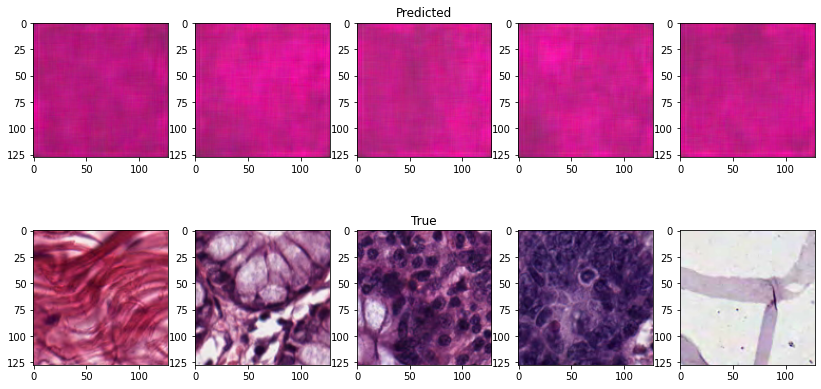

In [ ]:
from matplotlib import pyplot as plt
N_BATCH = 5
figs, axs = plt.subplots(nrows=2, ncols=N_BATCH, figsize=(14, 7))

for data in ds.unbatch().batch(N_BATCH):
        
    X, Y = data
    mean_logvar = model.forward_encoder(X)
    mean, logvar = mean_logvar[:, :latent_dim], mean_logvar[:, latent_dim:]

    x_sample = model.reparametrize(mean, logvar)
    imgs = model.forward_decoder(x_sample)
    
    for i, (y, img) in enumerate(zip(Y, imgs)):
        y *= 255
        img *= 255
        y = tf.keras.preprocessing.image.array_to_img(y)
        img = tf.keras.preprocessing.image.array_to_img(img)
        
        axs[0, 2].set_title('Predicted')
        axs[0, i].imshow(img)
        axs[1, 2].set_title('True')
        axs[1, i].imshow(y)
    break